In [666]:
# Import standard libraries for randomness, deep copying, and numerical operations
import random
import numpy as np
from copy import deepcopy

# Import libraries for image processing and data manipulation
from PIL import Image
import pandas as pd

# Import PyTorch core and utilities for deep learning
import torch
import torch.optim as optim  # Optimization algorithms
import torch.nn as nn  # Neural network modules
import torch.nn.functional as F  # Functional API for non-parametric operations

# Import PyTorch utilities for data loading and transformations
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler
from torchvision.transforms.v2 import Compose, ToImage, Normalize, ToPILImage, Resize, ToDtype

# Import dataset handling and learning rate schedulers
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

# Import visualization and web utilities
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import errno

from sklearn.linear_model import LinearRegression

# Set matplotlib style for better visuals
plt.style.use('fivethirtyeight')

In [667]:
# Train and test directories
TRAIN_DIR = 'train'
TEST_DIR = 'test'

## Architecture class

In [668]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def make_lr_fn(start_lr, end_lr, num_iter, mode='exp'):
        if mode == 'exp':
            def lr_lambda(iteration):
                return (end_lr / start_lr) ** (iteration / (num_iter - 1))
        elif mode == 'linear':
            def lr_lambda(iteration):
                return 1 + (end_lr - start_lr) * (iteration / (num_iter - 1)) / start_lr
        else:
            raise ValueError("Unknown mode: choose 'exp' or 'linear'")
        return lr_lambda

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train()  # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                         figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                 figsize=(1.5 * n_images, 1.5 * total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                        if is_vector \
                        else f'{layers[i]}\nfil#{row - start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
                    isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)

    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples] * n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                           'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = self.make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1 - alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

# Data Generation

This dataset was created by Mahsa Sanaei and can be found in his site: [Animal Image Dataset - Cats, Dogs, and Foxes](https://www.kaggle.com/datasets/snmahsa/animal-image-dataset-cats-dogs-and-foxes).


In [669]:
def figure1(folder='train'):
    dog = Image.open(f'{folder}/dog/0GVBGXNFKFO8.jpg')
    cat = Image.open(f'{folder}/cat/0ARKXCXCK9R2.jpg')
    hare = Image.open(f'{folder}/hare/0A3F79OMKWJW.jpg')

    images = [cat, dog, hare]
    titles = ['dog', 'cat', 'hare']

    fig, axs = plt.subplots(1, 3, figsize=(12, 5))
    for ax, image, title in zip(axs, images, titles):
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title)

    return fig

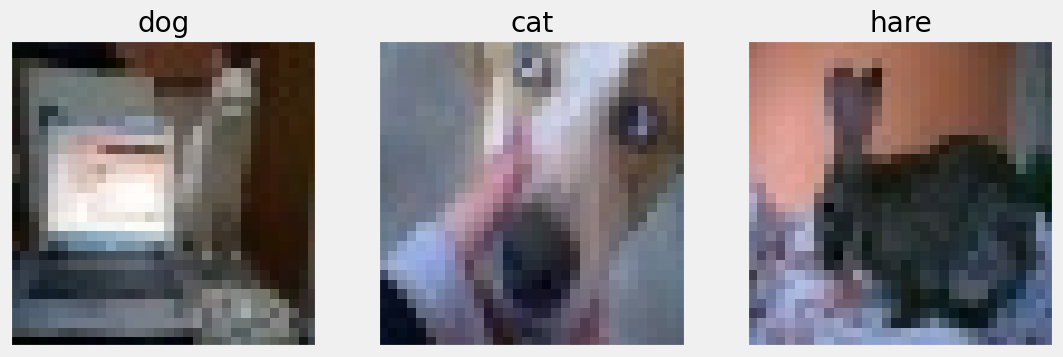

In [670]:
fig = figure1()

# Data Preparation

## ImageFolder

In [671]:
# Compose a sequence of preprocessing transforms
# 1) Resize images to 28×28 pixels
# 2) Ensure output is a PIL/torchvision Image (dropping any alpha channel)
# 3) Convert pixel values to float32 and scale from [0–255] to [0.0–1.0]
temp_transform = Compose([
    ToImage(),  # Convert tensor back to PIL Image (enforces RGB)
    ToDtype(torch.float32, scale=True)  # Cast to float32 and normalize pixel range
])

# Create an ImageFolder dataset from the 'train' directory
# Images are grouped by subfolder name as class labels, and each image is transformed
temp_dataset = ImageFolder(
    root=TRAIN_DIR,
    transform=temp_transform  # Apply the preprocessing pipeline to every image
)

In [672]:
# the second element of this tuple is the label
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 32, 32]), 0)

In [673]:
temp_dataset[0][0]

Image([[[0.6471, 0.6588, 0.6706,  ..., 0.6275, 0.6118, 0.6078],
        [0.6118, 0.6314, 0.6745,  ..., 0.6706, 0.6314, 0.6118],
        [0.5961, 0.6078, 0.6549,  ..., 0.6471, 0.6275, 0.6196],
        ...,
        [0.7216, 0.7294, 0.7451,  ..., 0.7804, 0.7529, 0.7529],
        [0.7137, 0.7176, 0.7490,  ..., 0.7882, 0.7843, 0.7647],
        [0.7137, 0.7137, 0.7451,  ..., 0.7725, 0.7765, 0.7608]],

       [[0.5294, 0.5412, 0.5529,  ..., 0.5255, 0.5176, 0.5137],
        [0.4941, 0.5137, 0.5569,  ..., 0.5765, 0.5373, 0.5255],
        [0.4824, 0.4941, 0.5412,  ..., 0.5686, 0.5490, 0.5412],
        ...,
        [0.6275, 0.6275, 0.6275,  ..., 0.6863, 0.6706, 0.6706],
        [0.6235, 0.6235, 0.6314,  ..., 0.6863, 0.6902, 0.6745],
        [0.6353, 0.6196, 0.6275,  ..., 0.6706, 0.6745, 0.6627]],

       [[0.3882, 0.3922, 0.4039,  ..., 0.3961, 0.3765, 0.3725],
        [0.3608, 0.3725, 0.4157,  ..., 0.4431, 0.3961, 0.3804],
        [0.3647, 0.3686, 0.4157,  ..., 0.4314, 0.4118, 0.4039],
        ..

In [674]:
# you have 1386 images
temp_dataset[1385][0].shape

torch.Size([3, 32, 32])

In [675]:
# Get total number of samples in the dataset
dataset_size = len(temp_dataset)
print(f"Dataset size: {dataset_size} images")

# Get number of classes
num_classes = len(temp_dataset.classes)
print(f"Number of classes: {num_classes}")

Dataset size: 1386 images
Number of classes: 3


## Standardization

In [676]:
temp_loader = DataLoader(temp_dataset, batch_size=16)
print(temp_loader.dataset)

Dataset ImageFolder
    Number of datapoints: 1386
    Root location: train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )


In [677]:
# Each column represents a channel
# first row is the number of data points
# second row is the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [ 7.5313,  7.2326,  6.8554],
        [ 3.5431,  3.6000,  3.6349]])

In [678]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[1386.0000, 1386.0000, 1386.0000],
        [ 721.0686,  692.0674,  576.5925],
        [ 264.9309,  261.7419,  266.0573]])

In [679]:
2142.5356 / 2520

0.8502125396825397

In [680]:
526.3025 / 2520

0.20885019841269842

In [681]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=[tensor(0.5203), tensor(0.4993), tensor(0.4160)], std=[tensor(0.1911), tensor(0.1888), tensor(0.1920)], inplace=False)

> Remember that PyTorch converts the pixel values into the [0, 1] range. The average mean value of a pixel for the red (first) channel is 0.8502, while its average standard deviation is 0.2089.

>> **IMPORTANT**: Always use the training set to compute statistics
for standardization! This avoid data leakage!!!

## The Real Datasets

In [682]:
# Define a pipeline of image transformations:
# 1) Resize each image to 28×28 pixels
# 2) Ensure the output is a PIL/torchvision image (dropping any alpha channel)
# 3) Cast pixels to float32 and scale from [0–255] to [0.0–1.0]
# 4) Apply the user-defined normalization (e.g., mean/std normalization)
composer = Compose([
    ToImage(),  # Convert to PIL Image in RGB
    ToDtype(torch.float32, scale=True),  # Cast to float32 and normalize to [0,1]
    normalizer  # Apply custom normalization transform
])

# Instantiate training and validation datasets from folders:
# - 'train' contains subfolders per class for training
# - 'test' likewise for validation
train_data = ImageFolder(root=TRAIN_DIR, transform=composer)
val_data = ImageFolder(root=TEST_DIR, transform=composer)

# Wrap datasets in DataLoaders for batching and shuffling:
# - batch_size=16 yields mini-batches of 16 images
# - shuffle=True randomizes training order each epoch
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)  # no shuffle for validation

In [683]:
def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = ['Cat', 'Dog', 'Hare']
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

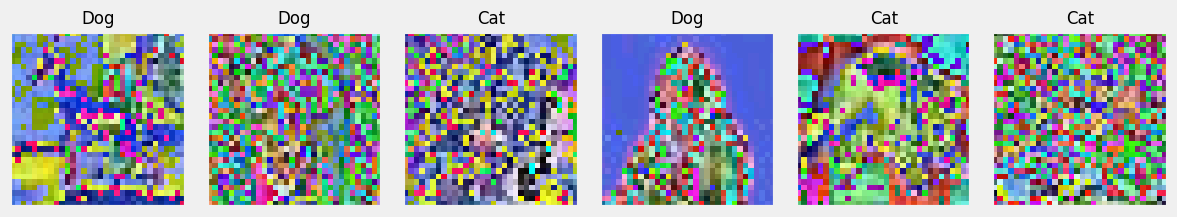

In [684]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

There is nothing wrong with the colors, it is just the effect of the standardization
of the pixel values.

# Dropout

In [685]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

In [686]:
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [687]:
torch.manual_seed(44)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.0000, 0.0000, 0.6000, 0.8000, 0.0000, 0.0000, 1.4000, 0.0000, 1.8000,
        2.0000, 2.2000])

In [688]:
output_train / spaced_points

tensor([0., 0., 2., 2., 0., 0., 2., 0., 2., 2., 2.])

In [689]:
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(8.8000)

In [690]:
dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [691]:
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

In [692]:
torch.manual_seed(17)
p = 0.5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                         weight=torch.ones(11), bias=torch.tensor(0))
                                for _ in range(1000)])

In [693]:
def plot_dist(ax, distrib_outputs, p):
    ax.hist(distrib_outputs, bins=np.linspace(0, 20, 21))
    ax.set_xlabel('Sum of Adjusted Outputs')
    ax.set_ylabel('# of Scenarios')
    ax.set_title('p = {:.2f}'.format(p))
    ax.set_ylim([0, 500])
    mean_value = distrib_outputs.mean()
    ax.plot([mean_value, mean_value], [0, 500], c='r', linestyle='--', label='Mean = {:.2f}'.format(mean_value))
    ax.legend()

In [694]:
def figure7(p, distrib_outputs):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plot_dist(ax, distrib_outputs, p)
    fig.tight_layout()
    return fig

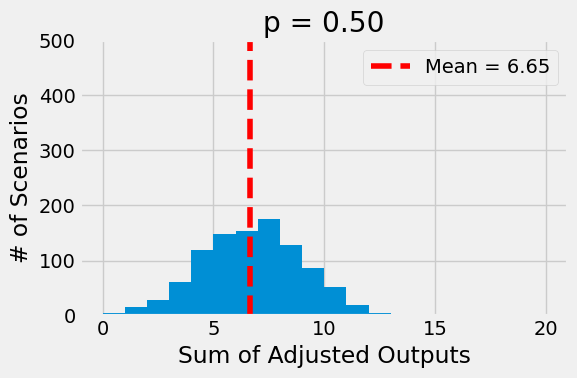

In [695]:
fig = figure7(p, distrib_outputs)

In [696]:
def figure8(ps=(0.1, 0.3, 0.5, 0.9)):
    spaced_points = torch.linspace(.1, 1.1, 11)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for ax, p in zip(axs.flat, ps):
        torch.manual_seed(17)
        distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                                 weight=torch.ones(11), bias=torch.tensor(0))
                                        for _ in range(1000)])
        plot_dist(ax, distrib_outputs, p)
        ax.label_outer()
    fig.tight_layout()
    return fig

On the left, if there is barely any dropout (p=0.10), the sum of adjusted outputs is
tightly distributed around the mean value. For more typical dropout probabilities
(like 30% or 50%), the distribution may take some more extreme values.


If we go to extremes, like a dropout probability of 90%, the distribution gets a bit
degenerated, I would say—it is pretty much all over the place (and it has a lot of
scenarios where everything gets dropped, hence the tall bar at zero).

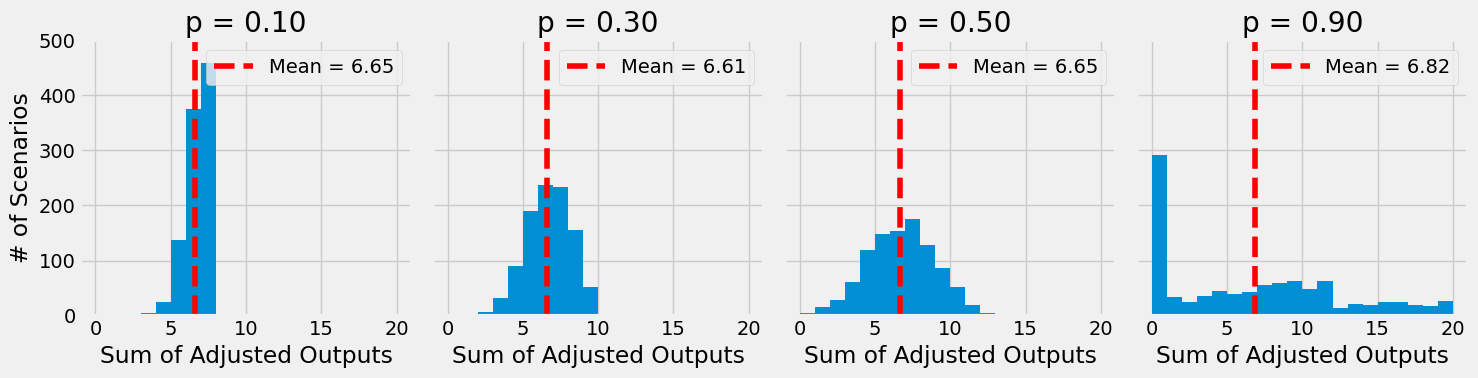

In [697]:
fig = figure8()

The variance of the distribution of outputs grows with the
dropout probability.


A higher dropout probability makes it harder for your model to
learn—that’s what regularization does.

### Two-Dimensional Dropout

In [698]:
def figure9(first_images, seed=17, p=.33):
    torch.manual_seed(seed)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(ToPILImage()(first_images[0]))
    axs[0].set_title('Original Image')
    axs[0].grid(False)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(ToPILImage()(F.dropout(first_images[:1], p=p)[0]))
    axs[1].set_title('Regular Dropout')
    axs[1].grid(False)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].imshow(ToPILImage()(F.dropout2d(first_images[:1], p=p)[0]))
    axs[2].set_title('Two-Dimensional Dropout')
    axs[2].grid(False)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    fig.tight_layout()
    return fig

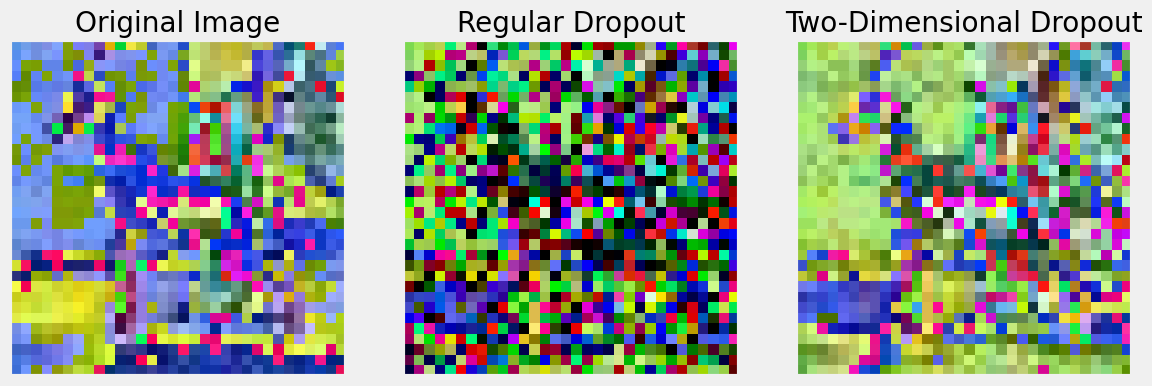

In [699]:
fig = figure9(first_images)

# Fancier Model

Let’s leave the Sequential model aside for now and build a model class again. This
time, our constructor method will take two arguments: ``n_filters`` and ``p``. We’ll use
``n_filters`` as the number of output channels for both convolutional blocks of our
model (yes, there are two now!). And, as you can see from the code below, we’ll use
``p`` as the probability of **dropout**.

In [700]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 6 * 6, 50)
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Case Study

## Model Configuration

The configuration part is short and straightforward:
- We create a model,
-  a loss function,
- and an optimizer.

The model will be an instance of our CNN2 class with five filters and a dropout
probability of 30%.

Our dataset has three classes, so we’re using
``nn.CrossEntropyLoss()`` (which will take the three logits produced by our model).

In [701]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

> Adaptive moment estimation (Adam) uses adaptive learning
rates, computing a learning rate for each parameter. Yes, you
read it right: Each parameter has a learning rate to call its own!


> If you dig into the state_dict() of an Adam optimizer, you’ll find
tensors shaped like the parameters of every layer in your model
that Adam will use to compute the corresponding learning rates.
True story!

In [702]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'decoupled_weight_decay': False,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

## Model Training

In [703]:
arch_cnn2 = Architecture(model_cnn2,
                         multi_loss_fn,
                         optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(10)

In [704]:
arch_cnn2.count_parameters()

9573

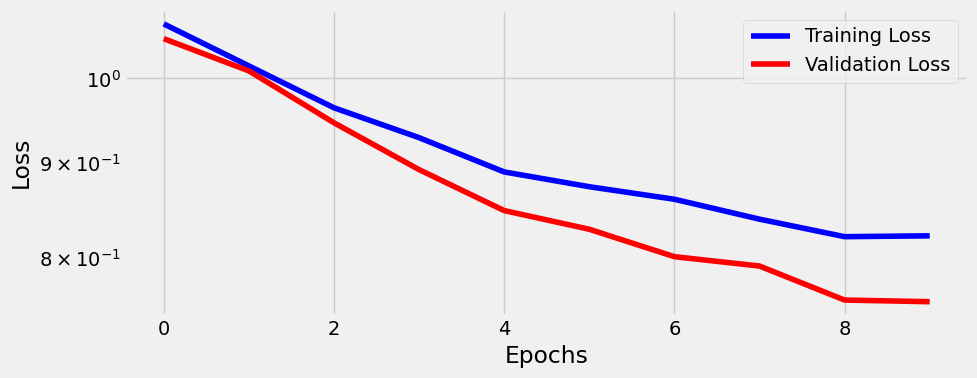

In [705]:
fig = arch_cnn2.plot_losses()

### Accuracy

In [706]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct)

tensor([[40, 52],
        [40, 52],
        [37, 52]])

In [707]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct).sum(axis=0)

tensor([117, 156])

In [708]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,
                                                                arch_cnn2.correct).sum(axis=0))

0.75

### Regularizing Effect

In [709]:
torch.manual_seed(13)
# Model Configuration
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)
# Model Training
arch_cnn2_nodrop = Architecture(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
arch_cnn2_nodrop.set_loaders(train_loader, val_loader)
arch_cnn2_nodrop.train(10)

In [710]:
def figure11(losses, val_losses, losses_nodrop, val_losses_nodrop):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses, 'b', label='Training Losses - Dropout')
    axs.plot(val_losses, 'r', label='Validation Losses - Dropout')
    axs.plot(losses_nodrop, 'b--', label='Training Losses - No Dropout')
    axs.plot(val_losses_nodrop, 'r--', label='Validation Losses - No Dropout')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Regularizing Effect')
    fig.legend(loc='lower left')
    fig.tight_layout()
    return fig

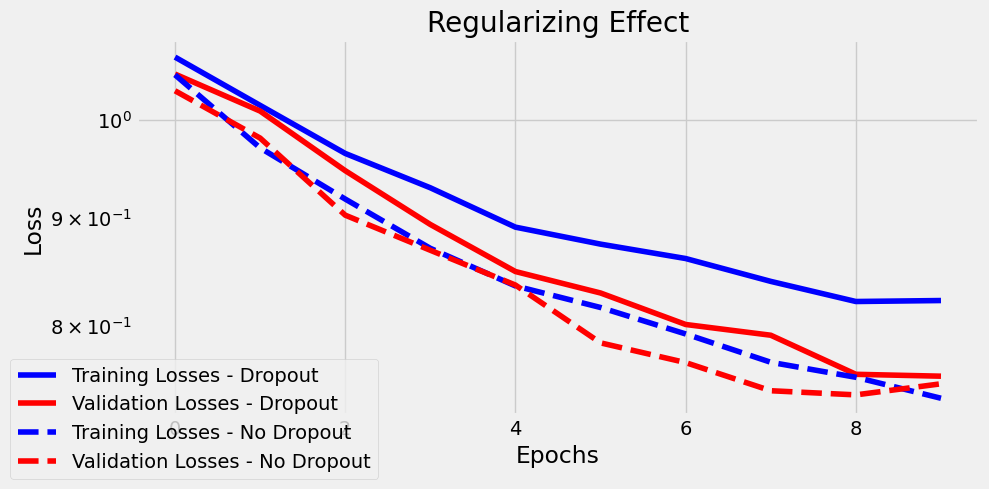

In [711]:
fig = figure11(arch_cnn2.losses, arch_cnn2.val_losses, arch_cnn2_nodrop.losses, arch_cnn2_nodrop.val_losses)

In [712]:
print(
    Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0),
    Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0)
)

tensor([ 953, 1386]) tensor([108, 156])


In [713]:
print(
    (lambda x: x[0].item() / x[1].item())(
        Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0)),
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0))
)

0.6875901875901876 0.6923076923076923


In [714]:
print(
    Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0),
    Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0)
)

tensor([ 923, 1386]) tensor([117, 156])


In [715]:
print(
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0)),
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0))
)

0.665945165945166 0.75


### Visualizing Filters

In [716]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

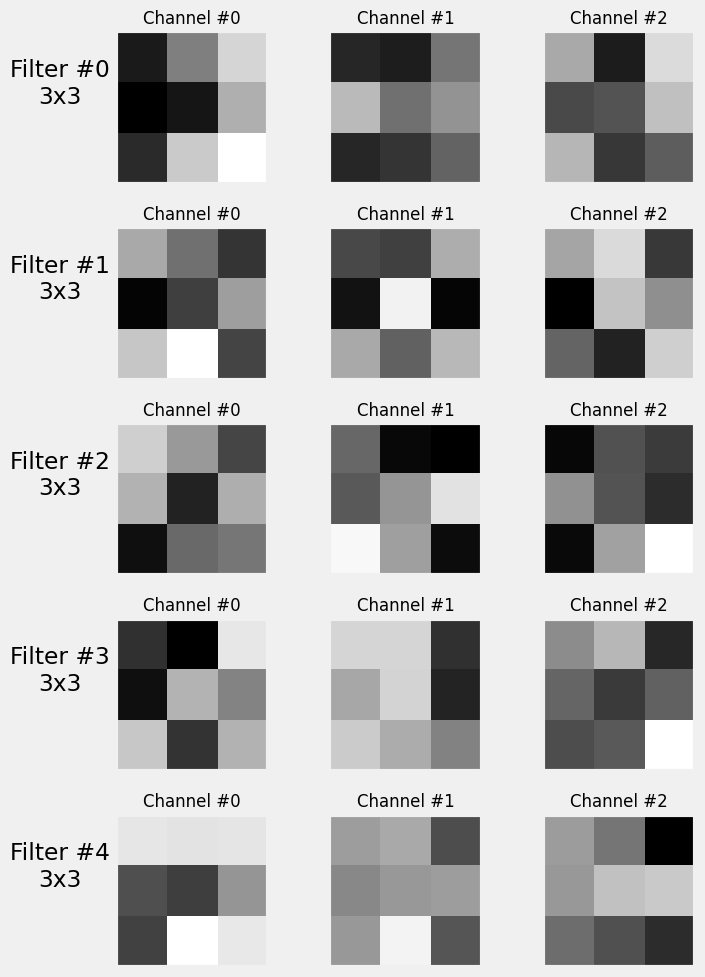

In [717]:
fig = arch_cnn2.visualize_filters('conv1')

In [718]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

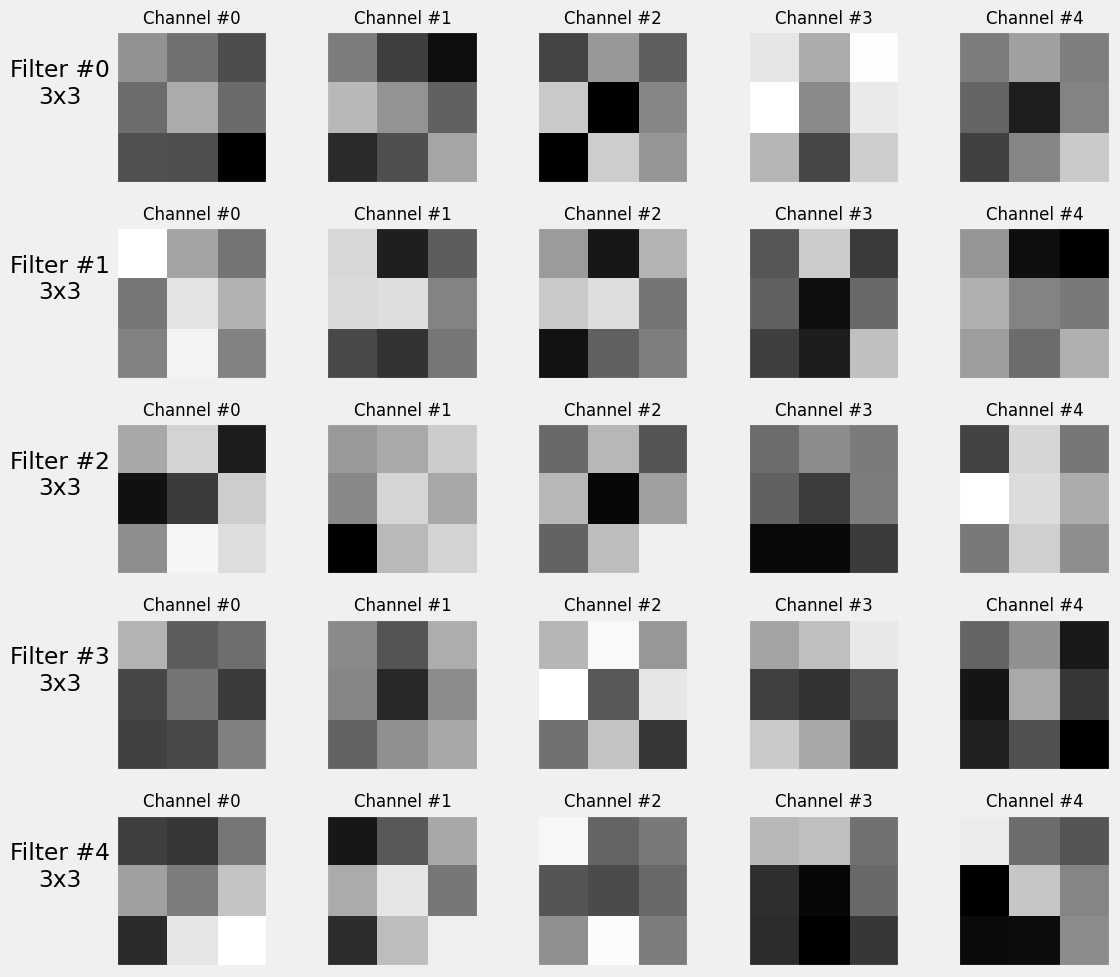

In [719]:
fig = arch_cnn2.visualize_filters('conv2')

# Learning Rates
##  Finding LR

In [720]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

In [721]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp')

In [722]:
lr_fn(np.arange(num_iter + 1))

array([ 1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

In [723]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

In [724]:
dummy_model = CNN2(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

In [725]:
dummy_optimizer.step()
dummy_scheduler.step()

In [726]:
dummy_scheduler.get_last_lr()[0]

np.float64(0.012589254117941673)

In [727]:
def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
    # Since the test updates both model and optimizer we need to store
    # their initial states to restore them in the end
    previous_states = {'model': deepcopy(self.model.state_dict()),
                       'optimizer': deepcopy(self.optimizer.state_dict())}
    # Retrieves the learning rate set in the optimizer
    start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

    # Builds a custom function and corresponding scheduler
    lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
    scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

    # Variables for tracking results and iterations
    tracking = {'loss': [], 'lr': []}
    iteration = 0

    # If there are more iterations than mini-batches in the data loader,
    # it will have to loop over it more than once
    while (iteration < num_iter):
        # That's the typical mini-batch inner loop
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            # Step 1
            yhat = self.model(x_batch)
            # Step 2
            loss = self.loss_fn(yhat, y_batch)
            # Step 3
            loss.backward()

            # Here we keep track of the losses (smoothed)
            # and the learning rates
            tracking['lr'].append(scheduler.get_last_lr()[0])
            if iteration == 0:
                tracking['loss'].append(loss.item())
            else:
                prev_loss = tracking['loss'][-1]
                smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                tracking['loss'].append(smoothed_loss)

            iteration += 1
            # Number of iterations reached
            if iteration == num_iter:
                break

            # Step 4
            self.optimizer.step()
            scheduler.step()
            self.optimizer.zero_grad()

    # Restores the original states
    self.optimizer.load_state_dict(previous_states['optimizer'])
    self.model.load_state_dict(previous_states['model'])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    else:
        fig = ax.get_figure()
    ax.plot(tracking['lr'], tracking['loss'])
    if step_mode == 'exp':
        ax.set_xscale('log')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Loss')
    fig.tight_layout()
    return tracking, fig

setattr(Architecture, 'lr_range_test', lr_range_test)

In [728]:
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

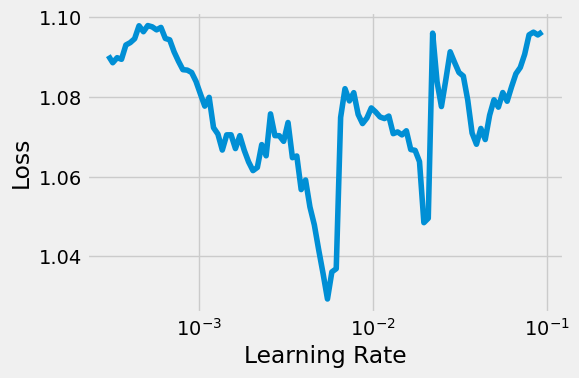

In [729]:
sbs_new = Architecture(new_model, multi_loss_fn, new_optimizer)
tracking, fig = sbs_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [730]:
def set_optimizer(self, optimizer):
    self.optimizer = optimizer

setattr(Architecture, 'set_optimizer', set_optimizer)

In [731]:
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
sbs_new.set_optimizer(new_optimizer)
sbs_new.set_loaders(train_loader, val_loader)
sbs_new.train(10)

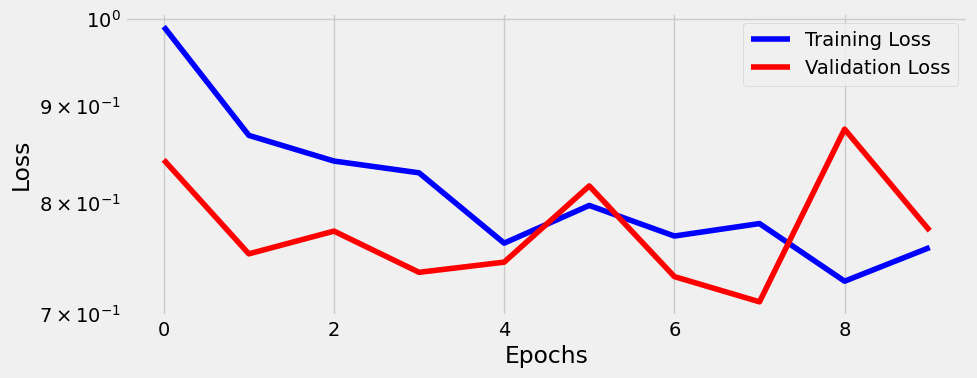

In [732]:
# This plot wasn't included in the book
fig = sbs_new.plot_losses()

## LR Finder

In [733]:
from torch_lr_finder import LRFinder

100%|██████████| 100/100 [00:00<00:00, 236.45it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.64E-03


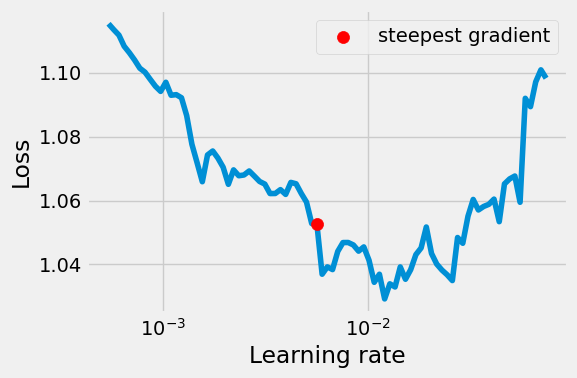

In [734]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()

In [735]:
def figure15(alpha=1/3, periods=5, steps=10):
    t = np.arange(1, steps+1)
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.bar(t-1, alpha*(1-alpha)**(t-1), label='EWMA')
    ax.bar(t-1, [1/periods]*periods + [0]*(10-periods), color='r', alpha=.3, label='MA')
    ax.set_xticks(t-1)
    ax.grid(False)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Weight')
    ax.set_title(r'$EWMA\ \alpha=\frac{1}{3}$ vs MA (5 periods)')
    ax.legend()
    fig.tight_layout()
    return fig

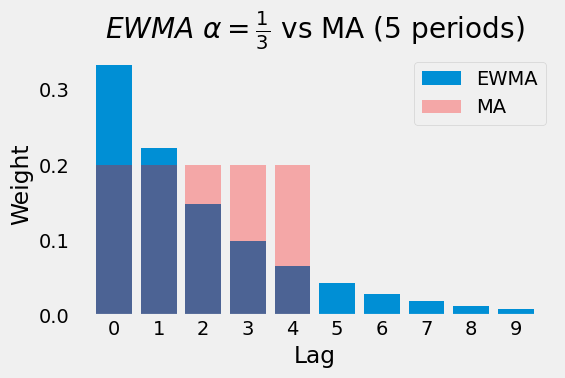

In [736]:
fig = figure15()

In [737]:
alpha = 1/3; T = 93
t = np.arange(1, T + 1)
age = alpha * sum((1 - alpha)**(t - 1) * t)
age

np.float64(3.0)

In [738]:
def EWMA(past_value, current_value, alpha):
    return (1 - alpha) * past_value + alpha * current_value

In [739]:
def calc_ewma(values, period):
    alpha = 2 / (period + 1)
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = EWMA(prev_value, v, alpha)
        result.append(new_value)
    return np.array(result)

In [740]:
def correction(averaged_value, beta, steps):
    return averaged_value / (1 - (beta ** steps))

In [741]:
def calc_corrected_ewma(values, period):
    ewma = calc_ewma(values, period)

    alpha = 2 / (period + 1)
    beta = 1 - alpha

    result = []
    for step, v in enumerate(ewma):
        adj_value = correction(v, beta, step + 1)
        result.append(adj_value)

    return np.array(result)

In [742]:

def ma_vs_ewma(values, periods=19):
    ma19 = pd.Series(values).rolling(min_periods=0, window=periods).mean()
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    ax.plot(values, c='k', label='Temperatures')
    ax.plot(ma19, c='k', linestyle='--', label='MA')
    ax.plot(calc_ewma(values, periods), c='r', linestyle='--', label='EWMA')
    ax.plot(calc_corrected_ewma(values, periods), c='r', linestyle='-', label='Bias-corrected EWMA')
    ax.set_title('MA vs EWMA')
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Days')
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

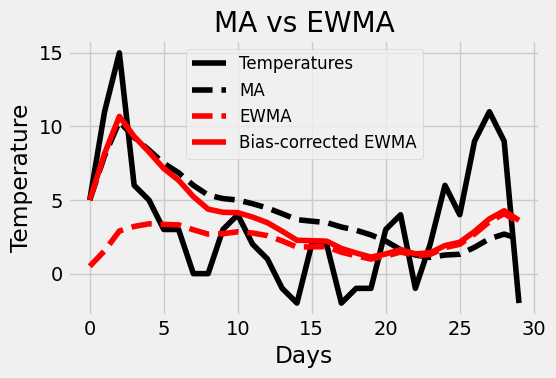

In [743]:
temperatures = np.array([5, 11, 15, 6, 5, 3, 3, 0, 0, 3, 4, 2, 1,
    -1, -2, 2, 2, -2, -1, -1, 3, 4, -1, 2, 6, 4, 9, 11, 9, -2])

fig = ma_vs_ewma(temperatures, periods=19)

In [744]:
optimizer = optim.Adam(model_cnn2.parameters(), lr=0.0125, betas=(0.9, 0.999), eps=1e-8)

In [745]:


torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
optimizer = optim.Adam(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss(reduction='mean')



In [746]:


setattr(Architecture, '_gradients', {})

def capture_gradients(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    self._gradients = {}

    def make_log_fn(name, parm_id):
        def log_fn(grad):
            self._gradients[name][parm_id].append(grad.tolist())
            return
        return log_fn

    for name, layer in self.model.named_modules():
        if name in layers_to_hook:
            self._gradients.update({name: {}})
            for parm_id, p in layer.named_parameters():
                if p.requires_grad:
                    self._gradients[name].update({parm_id: []})
                    log_fn = make_log_fn(name, parm_id)
                    self.handles[f'{name}.{parm_id}.grad'] = p.register_hook(log_fn)
    return

setattr(Architecture, 'capture_gradients', capture_gradients)



In [747]:
architecture_adam = Architecture(model, loss_fn, optimizer)
architecture_adam.set_loaders(train_loader, val_loader)
architecture_adam.capture_gradients('linear')
architecture_adam.train(10)
architecture_adam.remove_hooks()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1536x32 and 1x1)

In [ ]:
gradients = np.array(architecture_adam._gradients['linear']['weight']).squeeze()
corrected_gradients = calc_corrected_ewma(gradients, 19)
corrected_sq_gradients = calc_corrected_ewma(np.power(gradients, 2), 1999)
adapted_gradients = corrected_gradients / (np.sqrt(corrected_sq_gradients) + 1e-8)

In [ ]:
def figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    ax = axs[0]
    ax.plot(gradients, c='k', label=r'$Gradients$')
    ax.plot(corrected_gradients, c='r', linestyle='-', label=r'$Bias-corrected\ EWMA(grad)$')
    ax.set_title('EWMA for Smoothing')
    ax.set_ylabel('Gradient')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([-1.5, 1.5])
    ax.legend(fontsize=12)

    ax = axs[1]
    ax.plot(1/(np.sqrt(corrected_sq_gradients)+1e-8), c='b', linestyle='-', label=r'$\frac{1}{\sqrt{Bias-corrected\ EWMA(grad^2)}}$')
    ax.set_title('EWMA for Scaling')
    ax.set_ylabel('Factor')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([0, 5])
    ax.legend(fontsize=12)

    ax = axs[2]
    ax.plot(gradients, c='k', label='Gradients')
    ax.plot(adapted_gradients, c='g', label='Adapted Gradients')
    ax.set_title('Gradients')
    ax.set_ylabel('Gradient')
    ax.set_xlabel('Mini-batches')
    ax.set_ylim([-1.5, 1.5])
    ax.legend(fontsize=12)
    fig.tight_layout()
    return fig

In [ ]:
fig = figure17(gradients, corrected_gradients, corrected_sq_gradients, adapted_gradients)

In [ ]:
optimizer.state_dict()

In [ ]:
calc_ewma(gradients, 19)[-1], calc_ewma(np.power(gradients, 2), 1999)[-1]

In [ ]:
setattr(Architecture, '_parameters', {})

def capture_parameters(self, layers_to_hook):
    if not isinstance(layers_to_hook, list):
        layers_to_hook = [layers_to_hook]

    modules = list(self.model.named_modules())
    layer_names = {layer: name for name, layer in modules}

    self._parameters = {}

    for name, layer in modules:
        if name in layers_to_hook:
            self._parameters.update({name: {}})
            for parm_id, p in layer.named_parameters():
                self._parameters[name].update({parm_id: []})

    def fw_hook_fn(layer, inputs, outputs):
        name = layer_names[layer]
        for parm_id, parameter in layer.named_parameters():
            self._parameters[name][parm_id].append(parameter.tolist())

    self.attach_hooks(layers_to_hook, fw_hook_fn)
    return

setattr(Architecture, 'capture_parameters', capture_parameters)

In [ ]:
def compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader=None, schedulers=None, layers_to_hook='', n_epochs=50):
    results = {}
    model_state = deepcopy(model).state_dict()

    for desc, opt in optimizers.items():
        model.load_state_dict(model_state)

        optimizer = opt['class'](model.parameters(), **opt['parms'])

        sbs = Architecture(model, loss_fn, optimizer)
        sbs.set_loaders(train_loader, val_loader)

        try:
            if schedulers is not None:
                sched = schedulers[desc]
                scheduler = sched['class'](optimizer, **sched['parms'])
                sbs.set_lr_scheduler(scheduler)
        except KeyError:
            pass

        sbs.capture_parameters(layers_to_hook)
        sbs.capture_gradients(layers_to_hook)
        sbs.train(n_epochs)
        sbs.remove_hooks()

        parms = deepcopy(sbs._parameters)
        grads = deepcopy(sbs._gradients)

        lrs = sbs.learning_rates[:]
        if not len(lrs):
            lrs = [list(map(lambda p: p['lr'], optimizer.state_dict()['param_groups']))] * n_epochs

        results.update({desc: {'parms': parms,
                               'grads': grads,
                               'losses': np.array(sbs.losses),
                               'val_losses': np.array(sbs.val_losses),
                               'state': optimizer.state_dict(),
                               'lrs': lrs}})

    return results

In [ ]:
def contour_data(x_tensor, y_tensor):
    linr = LinearRegression()
    linr.fit(x_tensor, y_tensor)
    b, w = linr.intercept_, linr.coef_[0]

    # we have to split the ranges in 100 evenly spaced intervals each
    b_range = np.linspace(.7, 2.3, 101)
    w_range = np.linspace(.7, 2.3, 101)
    # meshgrid is a handy function that generates a grid of b and w
    # values for all combinations
    bs, ws = np.meshgrid(b_range, w_range)
    all_predictions = np.apply_along_axis(
        func1d=lambda x: bs + ws * x,
        axis=1,
        arr=x_tensor.numpy()
    )
    all_labels = y_tensor.numpy().reshape(-1, 1, 1)
    all_errors = (all_predictions - all_labels)
    all_losses = (all_errors ** 2).mean(axis=0)
    return b, w, bs, ws, all_losses

In [ ]:

def plot_paths(results, b, w, bs, ws, all_losses, axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, len(results), figsize=(5 * len(results), 5))
    axs = np.atleast_2d(axs)
    axs = [ax for row in axs for ax in row]
    for i, (ax, desc) in enumerate(zip(axs, results.keys())):
        biases = np.array(results[desc]['parms']['']['linear.bias']).squeeze()
        weights = np.array(results[desc]['parms']['']['linear.weight']).squeeze()
        ax.plot(biases, weights, '-o', linewidth=1, zorder=1, c='k', markersize=4)
        # Loss surface
        CS = ax.contour(bs[0, :], ws[:, 0], all_losses, cmap=plt.cm.jet, levels=12)
        ax.clabel(CS, inline=1, fontsize=10)
        ax.scatter(b, w, c='r', zorder=2, s=40)
        ax.set_xlim([.7, 2.3])
        ax.set_ylim([.7, 2.3])
        ax.set_xlabel('Bias')
        ax.set_ylabel('Weight')
        ax.set_title(desc)
        ax.label_outer()
    fig = ax.get_figure()
    fig.tight_layout()
    return fig

In [ ]:
def plot_losses(results, axs=None):
    n = len(results.keys())
    if axs is None:
        fig, axs = plt.subplots(1, n, figsize=(5*n, 4))
    else:
        fig = axs[0].get_figure()
    for ax, k in zip(axs, results.keys()):
        ax.plot(results[k]['losses'], label='Training Loss', c='b')
        ax.plot(results[k]['val_losses'], label='Validation Loss', c='r')
        ax.set_yscale('log')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_ylim([1e-3, 1])
        ax.set_title(k)
        ax.legend()
    fig.tight_layout()
    return fig

In [ ]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
             'Adam': {'class': optim.Adam, 'parms': {'lr': 0.1}}}
results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

b, w, bs, ws, all_losses = contour_data(x_tensor, y_tensor)
fig = plot_paths(results, b, w, bs, ws, all_losses)

In [ ]:
fig = plot_losses(results)

In [ ]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
             'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

In [ ]:
results['SGD + Momentum']['state']

In [ ]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

In [ ]:
# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD': {'class': optim.SGD, 'parms': {'lr': 0.1}},
              'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, n_epochs=10)

In [ ]:
def momentum(past_value, current_value, beta):
    return beta * past_value + current_value

def calc_momentum(values, beta):
    result = []
    for v in values:
        try:
            prev_value = result[-1]
        except IndexError:
            prev_value = 0

        new_value = momentum(prev_value, v, beta)
        result.append(new_value)
    return np.array(result)

def calc_nesterov(values, beta):
    result = calc_momentum(values, beta)
    return beta * result + values

def figure21(results):
    parm = 'linear.weight'

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    for i, ax in enumerate(axs):
        desc = list(results.keys())[i]
        gradients = np.array(results[desc]['grads'][''][parm]).squeeze()
        momentums = calc_momentum(gradients, 0.9)
        nesterovs = calc_nesterov(gradients, 0.9)
        ax.plot(gradients, c='k', label='Gradients')
        if i > 0:
            ax.plot(momentums, c='r', label='Momentums')
        if i > 1:
            ax.plot(nesterovs, c='b', label='Nesterov Momentums')
        ax.set_title(desc)
        ax.set_ylabel('Gradient')
        ax.set_xlabel('Mini-batches')
        ax.set_ylim([-2, 1.5])
        ax.legend(fontsize=12)

    fig.tight_layout()
    return fig

In [ ]:
fig = figure21(results)

In [ ]:
fig = plot_paths(results, b, w, bs, ws, all_losses)

In [ ]:
fig = plot_losses(results)

In [ ]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)

In [ ]:
for epoch in range(4):
    # trainin loop code goes here

    print(dummy_scheduler.get_last_lr())
    # First call optimizer's step
    dummy_optimizer.step()
    # Then call scheduler's step
    dummy_scheduler.step()

    dummy_optimizer.zero_grad()

In [ ]:


dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lambda epoch: 0.1 ** (epoch//2))
# The scheduler above is equivalent to this one
# dummy_scheduler = StepLR(dummy_optimizer, step_size=2, gamma=0.1)



In [ ]:
def plot_scheduler(dummy_optimizer, dummy_scheduler, logscale=True, ax=None):
    learning_rates = []
    for i in range(12):
        current_lr = list(map(lambda d: d['lr'], dummy_scheduler.optimizer.state_dict()['param_groups']))
        learning_rates.append(current_lr)
        dummy_optimizer.step()
        if isinstance(dummy_scheduler, ReduceLROnPlateau):
            dummy_loss = 0.1
            dummy_scheduler.step(dummy_loss)
        else:
            dummy_scheduler.step()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    ax.plot(learning_rates)
    if logscale:
        ax.set_yscale('log')
    ax.set_xlabel('Steps')
    ax.set_ylabel('Learning Rate')
    ax.set_title(type(dummy_scheduler).__name__)
    fig = ax.get_figure()
    fig.tight_layout()
    return fig

In [ ]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

In [ ]:
dummy_optimizer = optim.SGD([nn.Parameter(torch.randn(1))], lr=0.01)
dummy_scheduler = ReduceLROnPlateau(dummy_optimizer, patience=4, factor=0.1)

In [ ]:
fig = plot_scheduler(dummy_optimizer, dummy_scheduler)

In [ ]:
setattr(Architecture, 'scheduler', None)
setattr(Architecture, 'is_batch_lr_scheduler', False)

def set_lr_scheduler(self, scheduler):
    # Makes sure the scheduler in the argument is assigned to the
    # optimizer we're using in this class
    if scheduler.optimizer == self.optimizer:
        self.scheduler = scheduler
        if (isinstance(scheduler, optim.lr_scheduler.CyclicLR) or
            isinstance(scheduler, optim.lr_scheduler.OneCycleLR) or
            isinstance(scheduler, optim.lr_scheduler.CosineAnnealingWarmRestarts)):
            self.is_batch_lr_scheduler = True
        else:
            self.is_batch_lr_scheduler = False

setattr(Architecture, 'set_lr_scheduler', set_lr_scheduler)

In [ ]:
setattr(Architecture, 'learning_rates', [])

def _epoch_schedulers(self, val_loss):
    if self.scheduler:
        if not self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                self.scheduler.step(val_loss)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(Architecture, '_epoch_schedulers', _epoch_schedulers)

In [ ]:


def train(self, n_epochs, seed=42):
    # To ensure reproducibility of the training process
    self.set_seed(seed)

    for epoch in range(n_epochs):
        # Keeps track of the numbers of epochs
        # by updating the corresponding attribute
        self.total_epochs += 1

        # inner loop
        # Performs training using mini-batches
        loss = self._mini_batch(validation=False)
        self.losses.append(loss)

        # VALIDATION
        # no gradients in validation!
        with torch.no_grad():
            # Performs evaluation using mini-batches
            val_loss = self._mini_batch(validation=True)
            self.val_losses.append(val_loss)

        self._epoch_schedulers(val_loss)

        # If a SummaryWriter has been set...
        if self.writer:
            scalars = {'training': loss}
            if val_loss is not None:
                scalars.update({'validation': val_loss})
            # Records both losses for each epoch under the main tag "loss"
            self.writer.add_scalars(main_tag='loss',
                                    tag_scalar_dict=scalars,
                                    global_step=epoch)

    if self.writer:
        # Closes the writer
        self.writer.close()

setattr(Architecture, 'train', train)



In [ ]:
dummy_parm = [nn.Parameter(torch.randn(1))]
dummy_optimizer = optim.SGD(dummy_parm, lr=0.01)

dummy_scheduler1 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular')
dummy_scheduler2 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='triangular2')
dummy_scheduler3 = CyclicLR(dummy_optimizer, base_lr=1e-4, max_lr=1e-3, step_size_up=2, mode='exp_range', gamma=np.sqrt(.5))

In [ ]:
def figure26(dummy_optimizer, dummy_schedulers):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig = plot_scheduler(dummy_optimizer, dummy_schedulers[0], ax=axs[0], logscale=False)
    fig = plot_scheduler(dummy_optimizer, dummy_schedulers[1], ax=axs[1], logscale=False)
    fig = plot_scheduler(dummy_optimizer, dummy_schedulers[2], ax=axs[2], logscale=False)
    axs[0].set_ylim([9e-5, 1e-3])
    axs[1].set_ylim([9e-5, 1e-3])
    axs[2].set_ylim([9e-5, 1e-3])
    axs[0].set_title('CyclicLR - mode=triangular')
    axs[1].set_title('CyclicLR - mode=triangular2')
    axs[2].set_title('CyclicLR - mode=exp_range')
    fig.tight_layout()
    return fig

In [ ]:
fig = figure26(dummy_optimizer, (dummy_scheduler1, dummy_scheduler2, dummy_scheduler3))

In [ ]:


def _mini_batch_schedulers(self, frac_epoch):
    if self.scheduler:
        if self.is_batch_lr_scheduler:
            if isinstance(self.scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts):
                self.scheduler.step(self.total_epochs + frac_epoch)
            else:
                self.scheduler.step()

            current_lr = list(map(lambda d: d['lr'], self.scheduler.optimizer.state_dict()['param_groups']))
            self.learning_rates.append(current_lr)

setattr(Architecture, '_mini_batch_schedulers', _mini_batch_schedulers)



In [ ]:
def _mini_batch(self, validation=False):
    # The mini-batch can be used with both loaders
    # The argument `validation`defines which loader and
    # corresponding step function is going to be used
    if validation:
        data_loader = self.val_loader
        step_fn = self.val_step_fn
    else:
        data_loader = self.train_loader
        step_fn = self.train_step_fn

    if data_loader is None:
        return None

    n_batches = len(data_loader)
    # Once the data loader and step function, this is the same
    # mini-batch loop we had before
    mini_batch_losses = []
    for i, (x_batch, y_batch) in enumerate(data_loader):
        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

        if not validation:
            self._mini_batch_schedulers(i / n_batches)

    loss = np.mean(mini_batch_losses)
    return loss

setattr(Architecture, '_mini_batch', _mini_batch)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
for ax, nesterov in zip(axs.flat, [False, True]):
    torch.manual_seed(42)
    model = nn.Sequential()
    model.add_module('linear', nn.Linear(1, 1))
    loss_fn = nn.MSELoss(reduction='mean')
    optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=nesterov)

    sbs_scheduler = Architecture(model, loss_fn, optimizer)
    tracking, fig = sbs_scheduler.lr_range_test(train_loader, end_lr=1, num_iter=100, ax=ax)

    nest = ' + Nesterov' if nesterov else ''
    ax.set_title(f'Momentum{nest}')

In [ ]:
step_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
cyclic_scheduler = CyclicLR(optimizer, base_lr=0.025, max_lr=0.1, step_size_up=10, mode='triangular2')

In [ ]:


# Generating data for the plots
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')

optimizers = {'SGD + Momentum': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Momentum + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9}},
              'SGD + Nesterov': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Step': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}},
              'SGD + Nesterov + Cycle': {'class': optim.SGD, 'parms': {'lr': 0.1, 'momentum': 0.9, 'nesterov': True}}}

schedulers = {'SGD + Momentum + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Momentum + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}},
              'SGD + Nesterov + Step': {'class': StepLR, 'parms': {'step_size': 4, 'gamma': 0.5}},
              'SGD + Nesterov + Cycle': {'class': CyclicLR, 'parms': {'base_lr': 0.025, 'max_lr': 0.1, 'step_size_up': 10, 'mode': 'triangular2'}}}

results = compare_optimizers(model, loss_fn, optimizers, train_loader, val_loader, schedulers, n_epochs=10)



In [ ]:
def figure28(results, b, w, bs, ws, all_losses):
    axs = []
    fig = plt.figure(figsize=(15, 12))
    for i in range(3):
        axs.append(plt.subplot2grid((5, 3), (0, i), rowspan=2))
    for i in range(3):
        axs.append(plt.subplot2grid((5, 3), (3, i), rowspan=2))
    for i in range(3):
        axs.append(plt.subplot2grid((5, 3), (2, i)))

    lrs = [results[k]['lrs'] for k in ['SGD + Momentum', 'SGD + Momentum + Step', 'SGD + Momentum + Cycle']]
    for ax, l, title in zip(axs[6:], lrs, ['No Scheduler', 'StepLR', 'CyclicLR']):
        ax.plot(l)
        ax.set_title(title)
        if title == 'CyclicLR':
            ax.set_xlabel('Mini-batches')
        else:
            ax.set_xlabel('Epochs')
        ax.set_ylabel('Learning Rate')
        ax.set_ylim([0.0, .11])

    fig = plot_paths(results, b, w, bs, ws, all_losses, axs=axs[:6])
    for ax in axs[:6]:
        ax.set_xlabel('Bias')
    fig.tight_layout()

In [ ]:
fig = figure28(results, b, w, bs, ws, all_losses)

In [ ]:


fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flat
fig = plot_losses(results, axs)



In [ ]:


# Loads temporary dataset to build normalizer
temp_transform = Compose([Resize(28), ToImage(), ToDtype(torch.float32, scale=True)])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)
temp_loader = DataLoader(temp_dataset, batch_size=16)
normalizer = Architecture.make_normalizer(temp_loader)

# Builds transformation, datasets and data loaders
composer = Compose([Resize(28),
                    ToImage(),
                    ToDtype(torch.float32, scale=True),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)



In [ ]:


torch.manual_seed(13)
model_cnn3 = CNN2(n_feature=5, p=0.5)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=1e-3, momentum=0.9, nesterov=True)



In [ ]:


arch_cnn3 = Architecture(model_cnn3, multi_loss_fn, optimizer_cnn3)
tracking, fig = arch_cnn3.lr_range_test(train_loader, end_lr=2e-1, num_iter=100)



In [ ]:


optimizer_cnn3 = optim.SGD(model_cnn3.parameters(), lr=0.01, momentum=0.9, nesterov=True)
arch_cnn3.set_optimizer(optimizer_cnn3)

scheduler = CyclicLR(optimizer_cnn3, base_lr=1e-3, max_lr=0.01, step_size_up=len(train_loader), mode='triangular2')
arch_cnn3.set_lr_scheduler(scheduler)



In [ ]:
arch_cnn3.set_loaders(train_loader, val_loader)
arch_cnn3.train(10)

In [ ]:
fig = arch_cnn3.plot_losses()

In [ ]:


print(Architecture.loader_apply(train_loader, arch_cnn3.correct).sum(axis=0),
      Architecture.loader_apply(val_loader, arch_cnn3.correct).sum(axis=0))

